In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman


In [52]:
df_imagenet = pd.read_csv('./final_results/imagenet_results.csv')
df_cifar10 = pd.read_csv('./final_results/cifar10_results.csv')
df_cifar100 = pd.read_csv('./final_results/cifar100_results.csv')

In [53]:
def get_ece_15_bins(ece_str):
    ece_data = eval(ece_str)
    for ece_entry in ece_data:
        if ece_entry['n_bins'] == 15:
            return ece_entry['result']
    return None

In [54]:
def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

In [55]:
metrics_to_extract = [
    'ece', 'ECE_em', 'cwECE','ace', 'KSCE', 'KDECE', 'MMCE'
]

df_imagenet = df_imagenet[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
# 
metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE','cwCE_em', 'KSCE', 'KDECE', 'MMCE'
]
df_imagenet.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
for metric in metrics_to_extract:
    for dataset, df in [('IN', df_imagenet), ('C10', df_cifar10), ('C100', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))

In [57]:
merged_df = df_imagenet[['config'] + [f"{metric}_IN" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_C10" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_C100" for metric in metrics_to_extract]], on='config', how='outer'
)

In [36]:
merged_df = merged_df.fillna(0)

In [89]:
merged_df.columns

Index(['config', 'ECE_IN', 'ECE_em_IN', 'cwCE_IN', 'KSCE_IN', 'KDECE_IN',
       'MMCE_IN', 'ECE_C10', 'ECE_em_C10', 'cwCE_C10', 'KSCE_C10', 'KDECE_C10',
       'MMCE_C10', 'ECE_C100', 'ECE_em_C100', 'cwCE_C100', 'KSCE_C100',
       'KDECE_C100', 'MMCE_C100'],
      dtype='object')

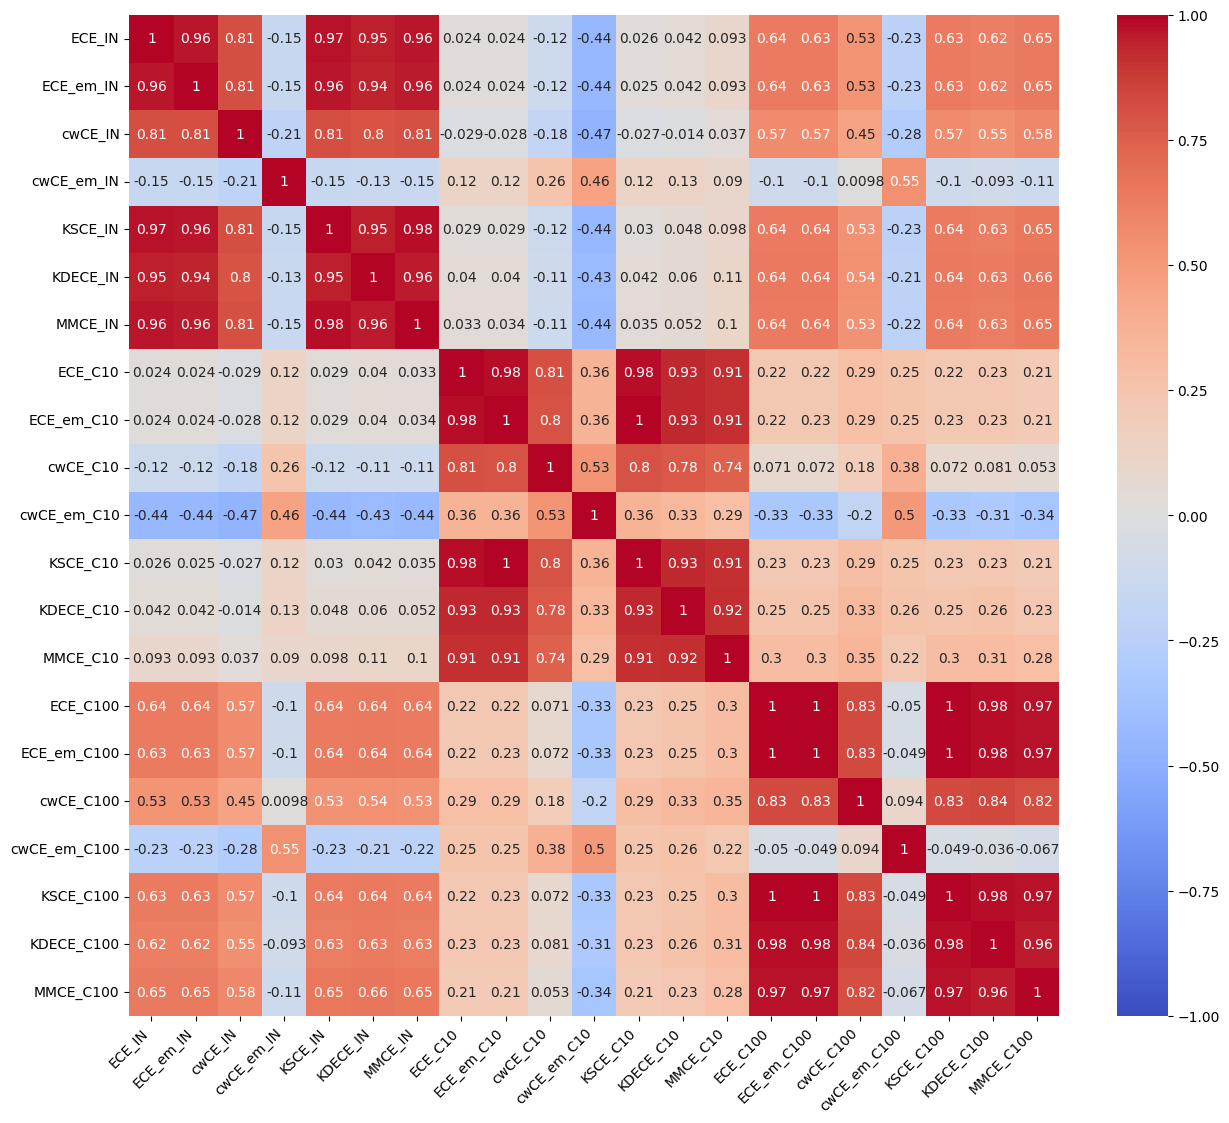

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['IN', 'C10', 'C100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['IN', 'C10', 'C100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/Kendall_Metric.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

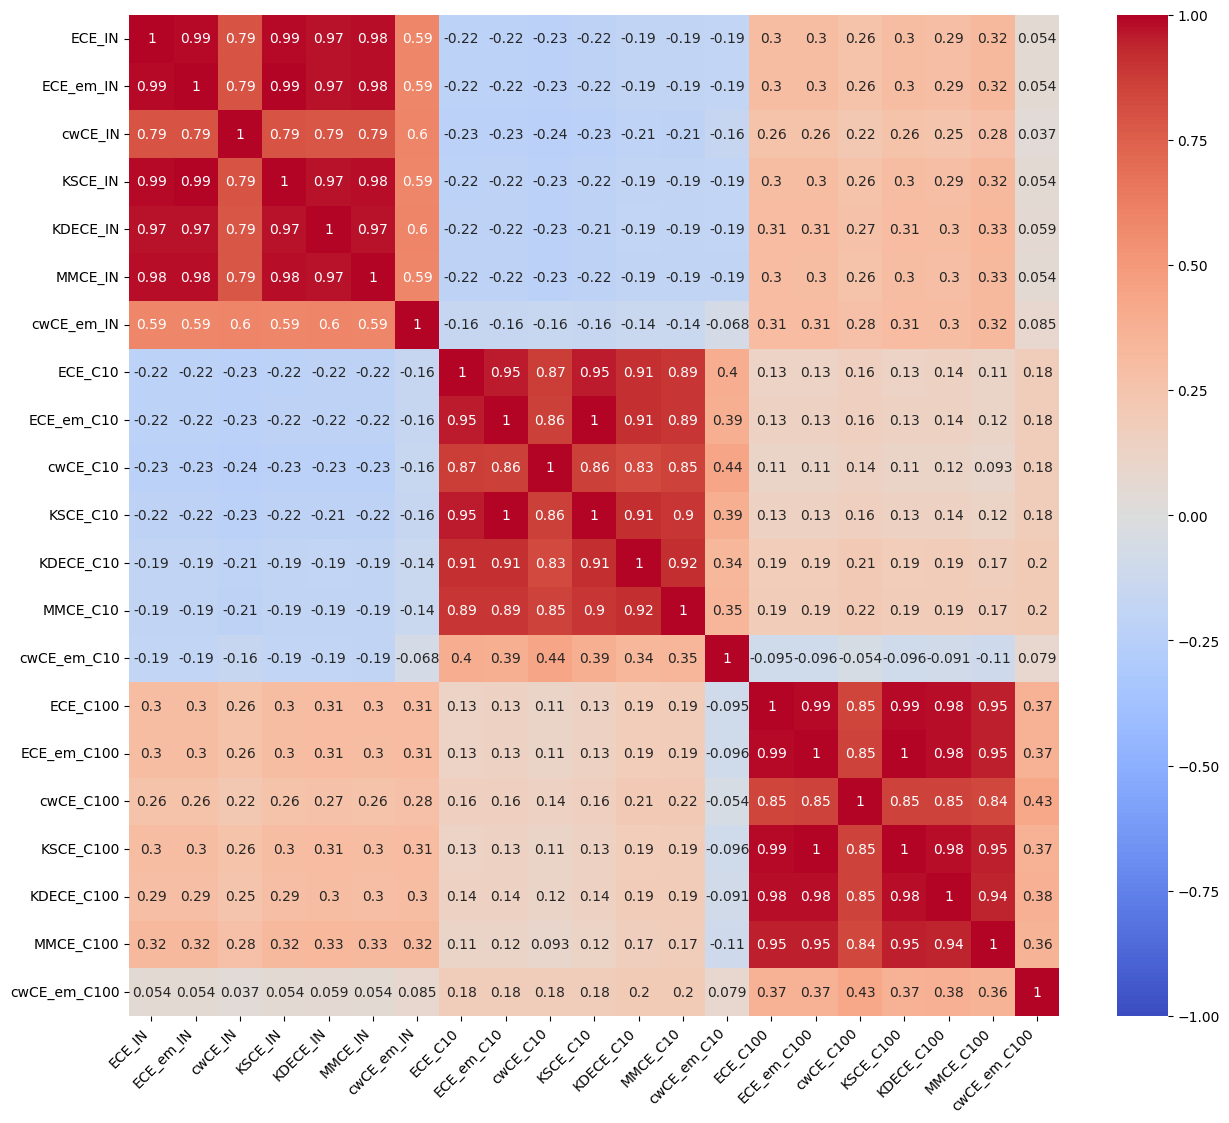

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman

df_imagenet = pd.read_csv('./final_results/imagenet_results.csv')
df_cifar10 = pd.read_csv('./final_results/cifar10_results.csv')
df_cifar100 = pd.read_csv('./final_results/cifar100_results.csv')

top_config_df1 = df_imagenet.nlargest(1000, 'info')['config']
top_config_df2 = df_cifar10.nlargest(1000, 'info')['config']
top_config_df3 = df_cifar100.nlargest(1000, 'info')['config']

# Concatenate these Series into a single Series
config_frames = [top_config_df1, top_config_df2, top_config_df3]
config_result = pd.concat(config_frames)

# Drop duplicates
unique_config_result = config_result.drop_duplicates()

# If you want to reset the index
unique_config_result = unique_config_result.reset_index(drop=True)

def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

metrics_to_extract = [
    'ece', 'ECE_em', 'cwECE', 'KSCE', 'KDECE', 'MMCE', 'ace'
]

df_imagenet = df_imagenet[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
# 
metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE', 'KSCE', 'KDECE', 'MMCE', 'cwCE_em'
]
df_imagenet.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
for metric in metrics_to_extract:
    for dataset, df in [('IN', df_imagenet), ('C10', df_cifar10), ('C100', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))

merged_df = df_imagenet[['config'] + [f"{metric}_IN" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_C10" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_C100" for metric in metrics_to_extract]], on='config', how='outer'
)
merged_df = merged_df.loc[merged_df['config'].isin(unique_config_result)]

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['IN', 'C10', 'C100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['IN', 'C10', 'C100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/Kendall_Metric_1000.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()


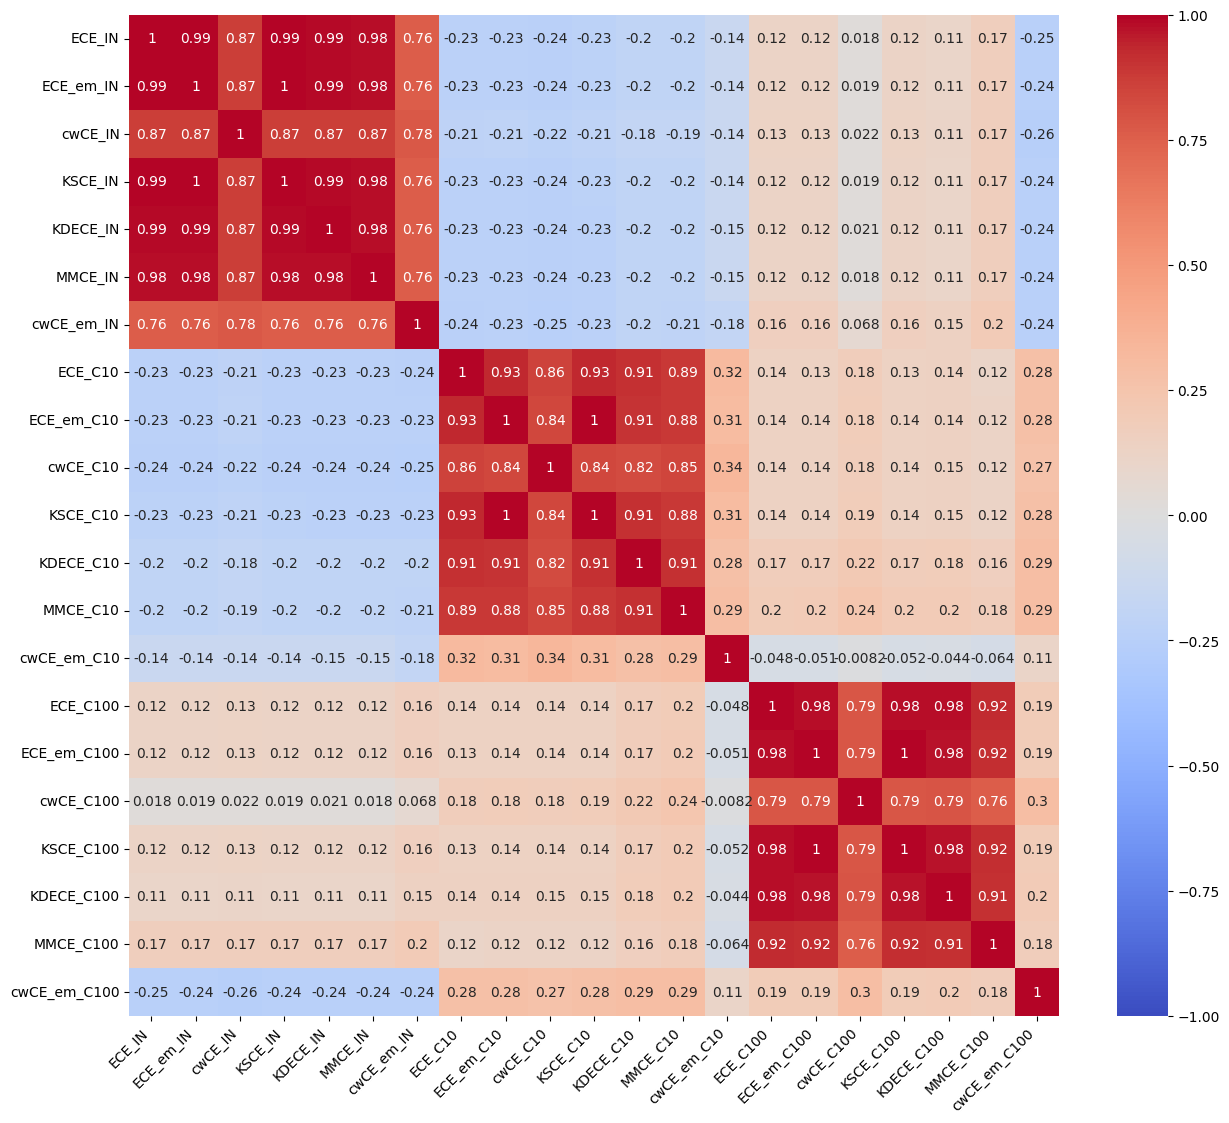

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman

df_imagenet = pd.read_csv('./final_results/imagenet_results.csv')
df_cifar10 = pd.read_csv('./final_results/cifar10_results.csv')
df_cifar100 = pd.read_csv('./final_results/cifar100_results.csv')

top_config_df1 = df_imagenet.nlargest(100, 'info')['config']
top_config_df2 = df_cifar10.nlargest(100, 'info')['config']
top_config_df3 = df_cifar100.nlargest(100, 'info')['config']

# Concatenate these Series into a single Series
config_frames = [top_config_df1, top_config_df2, top_config_df3]
config_result = pd.concat(config_frames)

# Drop duplicates
unique_config_result = config_result.drop_duplicates()

# If you want to reset the index
unique_config_result = unique_config_result.reset_index(drop=True)

def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

metrics_to_extract = [
    'ece', 'ECE_em', 'cwECE', 'KSCE', 'KDECE', 'MMCE', 'ace'
]

df_imagenet = df_imagenet[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
# 
metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE', 'KSCE', 'KDECE', 'MMCE', 'cwCE_em'
]
df_imagenet.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
for metric in metrics_to_extract:
    for dataset, df in [('IN', df_imagenet), ('C10', df_cifar10), ('C100', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))

merged_df = df_imagenet[['config'] + [f"{metric}_IN" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_C10" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_C100" for metric in metrics_to_extract]], on='config', how='outer'
)
merged_df = merged_df.loc[merged_df['config'].isin(unique_config_result)]

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['IN', 'C10', 'C100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['IN', 'C10', 'C100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/Kendall_Metric_100.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()


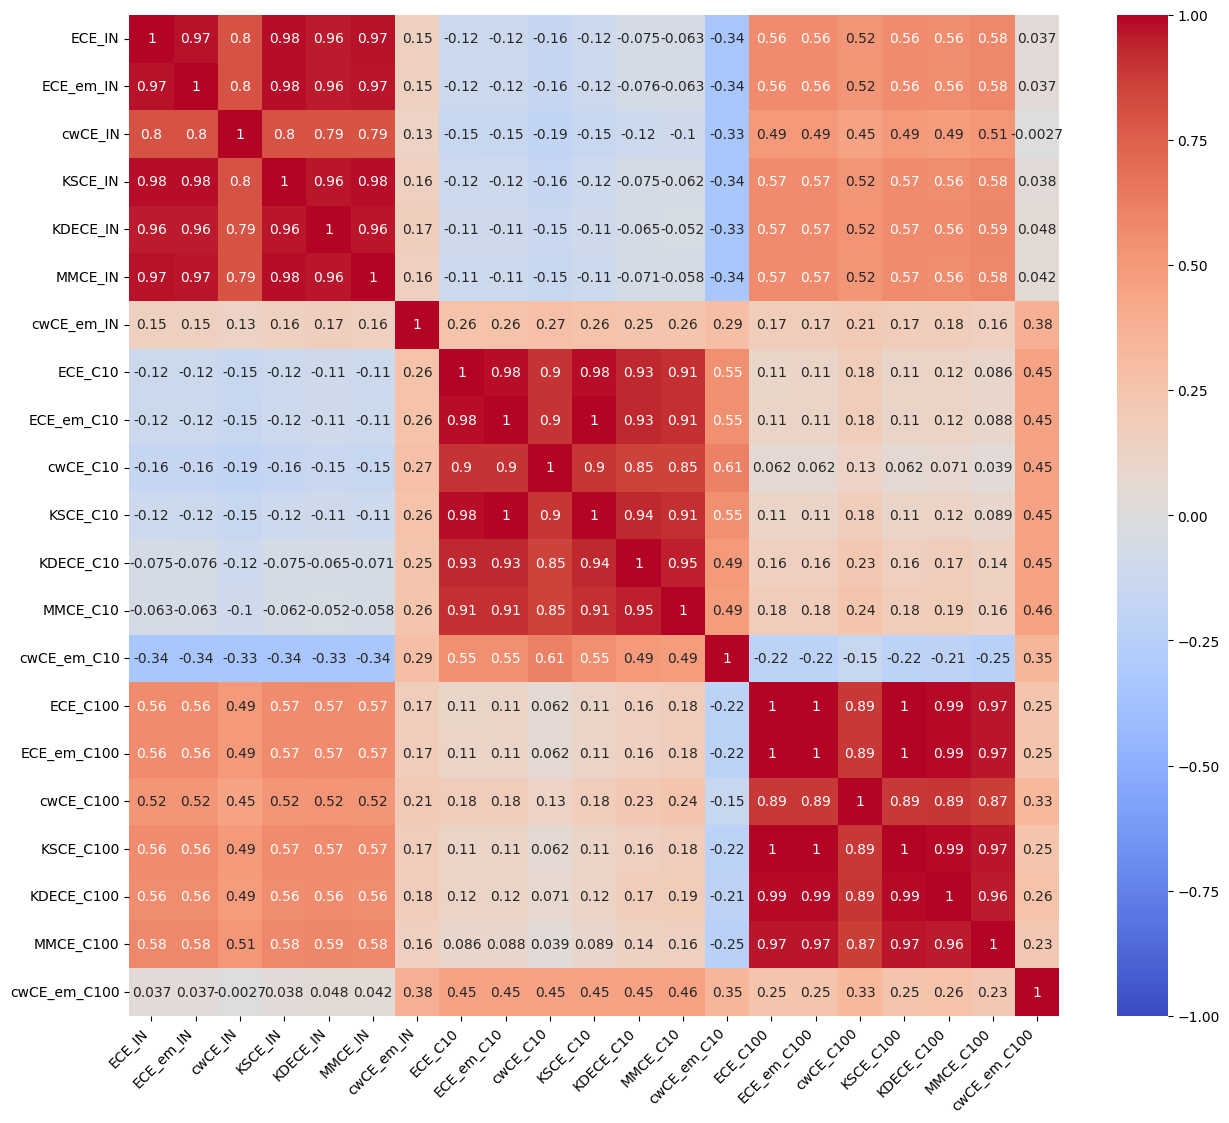

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman

df_imagenet = pd.read_csv('./final_results/imagenet_results.csv')
df_cifar10 = pd.read_csv('./final_results/cifar10_results.csv')
df_cifar100 = pd.read_csv('./final_results/cifar100_results.csv')

top_config_df1 = df_imagenet.nlargest(5000, 'info')['config']
top_config_df2 = df_cifar10.nlargest(5000, 'info')['config']
top_config_df3 = df_cifar100.nlargest(5000, 'info')['config']

# Concatenate these Series into a single Series
config_frames = [top_config_df1, top_config_df2, top_config_df3]
config_result = pd.concat(config_frames)

# Drop duplicates
unique_config_result = config_result.drop_duplicates()

# If you want to reset the index
unique_config_result = unique_config_result.reset_index(drop=True)

def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

metrics_to_extract = [
    'ece', 'ECE_em', 'cwECE', 'KSCE', 'KDECE', 'MMCE', 'ace'
]

df_imagenet = df_imagenet[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
# 
metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE', 'KSCE', 'KDECE', 'MMCE', 'cwCE_em'
]
df_imagenet.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
for metric in metrics_to_extract:
    for dataset, df in [('IN', df_imagenet), ('C10', df_cifar10), ('C100', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))

merged_df = df_imagenet[['config'] + [f"{metric}_IN" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_C10" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_C100" for metric in metrics_to_extract]], on='config', how='outer'
)
merged_df = merged_df.loc[merged_df['config'].isin(unique_config_result)]

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['IN', 'C10', 'C100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['IN', 'C10', 'C100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Rotate the bottom labelsx
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/Kendall_Metric_5000.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()


In [4]:
df_imagenet_post = pd.read_csv('./final_results/imagenet_post.csv')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman

df_imagenet = pd.read_csv('./final_results/imagenet_results.csv')
df_cifar10 = pd.read_csv('./final_results/cifar10_results.csv')
df_cifar100 = pd.read_csv('./final_results/cifar100_results.csv')

df_imagenet_post = pd.read_csv('./final_results/imagenet_post.csv')
df_cifar10_post = pd.read_csv('./final_results/cifar10_post.csv')
df_cifar100_post = pd.read_csv('./final_results/cifar100_post.csv')



# # Concatenate these Series into a single Series
# config_frames = [top_config_df1, top_config_df2, top_config_df3]
# config_result = pd.concat(config_frames)

# # Drop duplicates
# unique_config_result = config_result.drop_duplicates()

# # If you want to reset the index
# unique_config_result = unique_config_result.reset_index(drop=True)

def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

metrics_to_extract = [
    'ece'
]

df_imagenet = df_imagenet[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]

df_imagenet_post = df_imagenet_post[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10_post = df_cifar10_post[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100_post = df_cifar100_post[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]

# 
metrics_to_extract = [
    'ECE'
]
df_imagenet.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract

df_imagenet_post.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10_post.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100_post.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract



for metric in metrics_to_extract:
    for dataset, df in [('IN_pre', df_imagenet), ('C10_pre', df_cifar10), ('C100_pre', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))

for metric in metrics_to_extract:
    for dataset, df in [('IN_post', df_imagenet_post), ('C10_post', df_cifar10_post), ('C100_post', df_cifar100_post)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))


merged_df = df_imagenet[['config'] + [f"{metric}_IN_pre" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_C10_pre" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_C100_pre" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_imagenet_post[['config'] + [f"{metric}_IN_post" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar10_post[['config'] + [f"{metric}_C10_post" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100_post[['config'] + [f"{metric}_C100_post" for metric in metrics_to_extract]], on='config', how='outer'
)



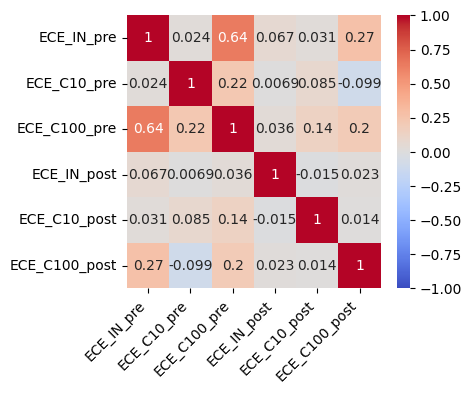

In [3]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['IN_pre', 'C10_pre', 'C100_pre','IN_post', 'C10_post', 'C100_post']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['IN_pre', 'C10_pre', 'C100_pre','IN_post', 'C10_post', 'C100_post'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Select the desired metrics
selected_metrics = ['ECE_IN_pre', 'ECE_C10_pre', 'ECE_C100_pre','ECE_IN_post', 'ECE_C10_post', 'ECE_C100_post']
corr_matrix_selected = corr_matrix.loc[selected_metrics, selected_metrics]

# Create a correlation heatmap using seaborn
plt.figure(figsize=(4.09, 3.546))
sns.heatmap(corr_matrix_selected.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/rebuttal_4.1.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

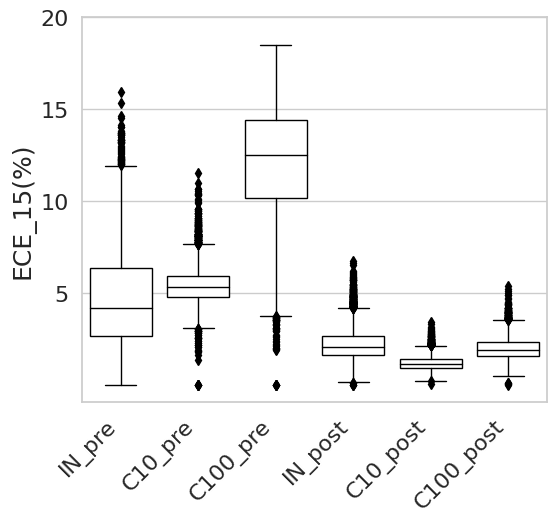

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman

df_imagenet = pd.read_csv('./final_results/imagenet_results.csv')
df_cifar10 = pd.read_csv('./final_results/cifar10_results.csv')
df_cifar100 = pd.read_csv('./final_results/cifar100_results.csv')

df_imagenet_post = pd.read_csv('./final_results/imagenet_post.csv')
df_cifar10_post = pd.read_csv('./final_results/cifar10_post.csv')
df_cifar100_post = pd.read_csv('./final_results/cifar100_post.csv')



# # Concatenate these Series into a single Series
# config_frames = [top_config_df1, top_config_df2, top_config_df3]
# config_result = pd.concat(config_frames)

# # Drop duplicates
# unique_config_result = config_result.drop_duplicates()

# # If you want to reset the index
# unique_config_result = unique_config_result.reset_index(drop=True)

def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

metrics_to_extract = [
    'ece'
]

df_imagenet = df_imagenet[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]

df_imagenet_post = df_imagenet_post[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10_post = df_cifar10_post[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100_post = df_cifar100_post[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]

# 
metrics_to_extract = [
    'ECE'
]
df_imagenet.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract

df_imagenet_post.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10_post.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100_post.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract



for metric in metrics_to_extract:
    for dataset, df in [('IN_pre', df_imagenet), ('C10_pre', df_cifar10), ('C100_pre', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))

for metric in metrics_to_extract:
    for dataset, df in [('IN_post', df_imagenet_post), ('C10_post', df_cifar10_post), ('C100_post', df_cifar100_post)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))


merged_df = df_imagenet[['config'] + [f"{metric}_IN_pre" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_C10_pre" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_C100_pre" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_imagenet_post[['config'] + [f"{metric}_IN_post" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar10_post[['config'] + [f"{metric}_C10_post" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100_post[['config'] + [f"{metric}_C100_post" for metric in metrics_to_extract]], on='config', how='outer'
)



title_font_size = 22
axis_label_font_size = 18
tick_label_font_size = 16

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style and font sizes
title_font_size = 22
axis_label_font_size = 18
tick_label_font_size = 16
sns.set(style="whitegrid")

# Columns to be renamed
columns_to_rename = {
    'ECE_IN_pre': 'IN_pre', 
    'ECE_C10_pre': 'C10_pre', 
    'ECE_C100_pre': 'C100_pre', 
    'ECE_IN_post': 'IN_post', 
    'ECE_C10_post': 'C10_post', 
    'ECE_C100_post': 'C100_post'
}

# Rename columns
merged_df = merged_df.rename(columns=columns_to_rename)

# Convert the DataFrame to a long-form or tidy DataFrame
long_form_df = pd.melt(merged_df, id_vars=[], value_vars=columns_to_rename.values())

# Multiply the values by 100 to convert them to percentages
long_form_df["value"] *= 100

# Plot the data
plt.figure(figsize=(6, 5))
ax = sns.boxplot(x="variable", y="value", data=long_form_df,
                 boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                 capprops=dict(color='black', linewidth=1),
                 whiskerprops=dict(color='black', linewidth=1),
                 medianprops=dict(color='black', linewidth=1),
                 flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set title and labels
# ax.set_title("Boxplots of Attributes", fontsize=title_font_size)
ticks = [5, 10, 15, 20] 
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)

ax.set_xlabel("", fontsize=axis_label_font_size)
ax.set_ylabel("ECE_15(%)", fontsize=axis_label_font_size)

# Set tick labels font size
ax.tick_params(axis='x', labelsize=tick_label_font_size)
ax.tick_params(axis='y', labelsize=tick_label_font_size)

plt.xticks(rotation=45, ha='right')
plt.savefig("fig/rebuttal_4.1.1.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

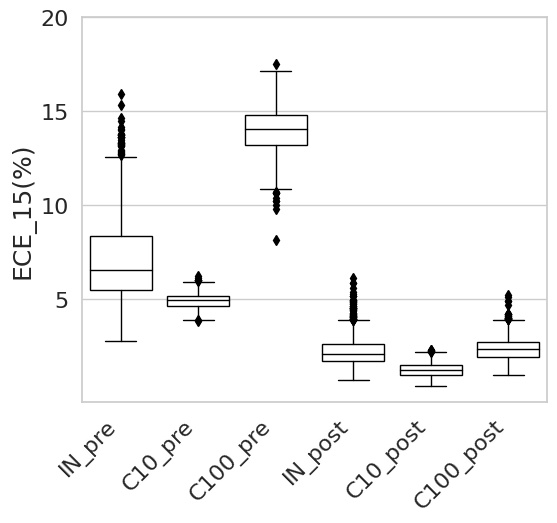

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman

df_imagenet = pd.read_csv('./final_results/imagenet_results.csv')
df_cifar10 = pd.read_csv('./final_results/cifar10_results.csv')
df_cifar100 = pd.read_csv('./final_results/cifar100_results.csv')

df_imagenet_post = pd.read_csv('./final_results/imagenet_post.csv')
df_cifar10_post = pd.read_csv('./final_results/cifar10_post.csv')
df_cifar100_post = pd.read_csv('./final_results/cifar100_post.csv')

top_config_df1 = df_imagenet.nlargest(1000, 'info')['config']
top_config_df2 = df_cifar10.nlargest(1000, 'info')['config']
top_config_df3 = df_cifar100.nlargest(1000, 'info')['config']

top_config_df4 = df_imagenet_post.nlargest(1000, 'info')['config']
top_config_df5 = df_cifar10_post.nlargest(1000, 'info')['config']
top_config_df6 = df_cifar100_post.nlargest(1000, 'info')['config']

# Concatenate these Series into a single Series
config_frames = [top_config_df1, top_config_df2, top_config_df3,
                 top_config_df4,top_config_df5,top_config_df6]
config_result = pd.concat(config_frames)

# Drop duplicates
unique_config_result = config_result.drop_duplicates()

# If you want to reset the index
unique_config_result = unique_config_result.reset_index(drop=True)

def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

metrics_to_extract = [
    'ece'
]

df_imagenet = df_imagenet[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]

df_imagenet_post = df_imagenet_post[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10_post = df_cifar10_post[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100_post = df_cifar100_post[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]

# 
metrics_to_extract = [
    'ECE'
]
df_imagenet.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract

df_imagenet_post.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10_post.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100_post.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract



for metric in metrics_to_extract:
    for dataset, df in [('IN_pre', df_imagenet), ('C10_pre', df_cifar10), ('C100_pre', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))

for metric in metrics_to_extract:
    for dataset, df in [('IN_post', df_imagenet_post), ('C10_post', df_cifar10_post), ('C100_post', df_cifar100_post)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))


merged_df = df_imagenet[['config'] + [f"{metric}_IN_pre" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_C10_pre" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_C100_pre" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_imagenet_post[['config'] + [f"{metric}_IN_post" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar10_post[['config'] + [f"{metric}_C10_post" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100_post[['config'] + [f"{metric}_C100_post" for metric in metrics_to_extract]], on='config', how='outer'
)

merged_df = merged_df.loc[merged_df['config'].isin(unique_config_result)]

title_font_size = 22
axis_label_font_size = 18
tick_label_font_size = 16

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style and font sizes
title_font_size = 22
axis_label_font_size = 18
tick_label_font_size = 16
sns.set(style="whitegrid")

# Columns to be renamed
columns_to_rename = {
    'ECE_IN_pre': 'IN_pre', 
    'ECE_C10_pre': 'C10_pre', 
    'ECE_C100_pre': 'C100_pre', 
    'ECE_IN_post': 'IN_post', 
    'ECE_C10_post': 'C10_post', 
    'ECE_C100_post': 'C100_post'
}

# Rename columns
merged_df = merged_df.rename(columns=columns_to_rename)

# Convert the DataFrame to a long-form or tidy DataFrame
long_form_df = pd.melt(merged_df, id_vars=[], value_vars=columns_to_rename.values())

# Multiply the values by 100 to convert them to percentages
long_form_df["value"] *= 100

# Plot the data
plt.figure(figsize=(6, 5))
ax = sns.boxplot(x="variable", y="value", data=long_form_df,
                 boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                 capprops=dict(color='black', linewidth=1),
                 whiskerprops=dict(color='black', linewidth=1),
                 medianprops=dict(color='black', linewidth=1),
                 flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set title and labels
# ax.set_title("Boxplots of Attributes", fontsize=title_font_size)
ticks = [5, 10, 15, 20] 
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)

ax.set_xlabel("", fontsize=axis_label_font_size)
ax.set_ylabel("ECE_15(%)", fontsize=axis_label_font_size)

# Set tick labels font size
ax.tick_params(axis='x', labelsize=tick_label_font_size)
ax.tick_params(axis='y', labelsize=tick_label_font_size)

plt.xticks(rotation=45, ha='right')
plt.savefig("fig/rebuttal_4.1.2.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_2010294/4131199283.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)


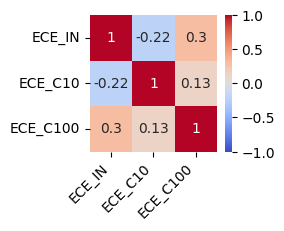

In [111]:
merged_df = merged_df.loc[merged_df['config'].isin(unique_config_result)]
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['IN', 'C10', 'C100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['IN', 'C10', 'C100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Select the desired metrics
selected_metrics = ['ECE_IN', 'ECE_C10', 'ECE_C100']
corr_matrix_selected = corr_matrix.loc[selected_metrics, selected_metrics]

# Create a correlation heatmap using seaborn
plt.figure(figsize=(2.045, 1.773))
sns.heatmap(corr_matrix_selected.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

# plt.savefig("fig/Kendall_Metric_selected.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

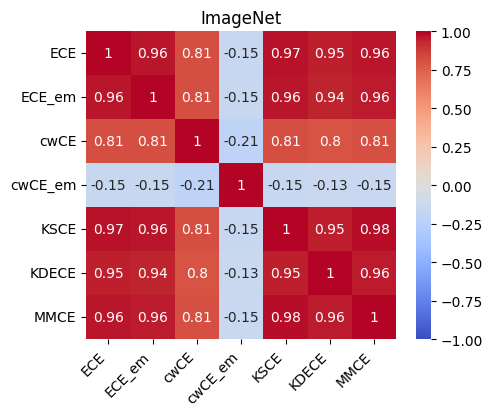

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['IN']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['IN'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

corr_matrix.columns = ['ECE', 'ECE_em', 'cwCE', 'cwCE_em', 'KSCE',
       'KDECE', 'MMCE']
corr_matrix.index = ['ECE', 'ECE_em', 'cwCE', 'cwCE_em', 'KSCE',
       'KDECE', 'MMCE']

# Create a correlation heatmap using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('ImageNet')
plt.xticks(rotation=45, ha='right')
plt.savefig("fig/Kendall_Metric_IN.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['C10']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['C10'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

corr_matrix.columns = ['ECE', 'ECE_em', 'cwCE', 'cwCE_em', 'KSCE',
       'KDECE', 'MMCE']
corr_matrix.index = ['ECE', 'ECE_em', 'cwCE', 'cwCE_em', 'KSCE',
       'KDECE', 'MMCE']



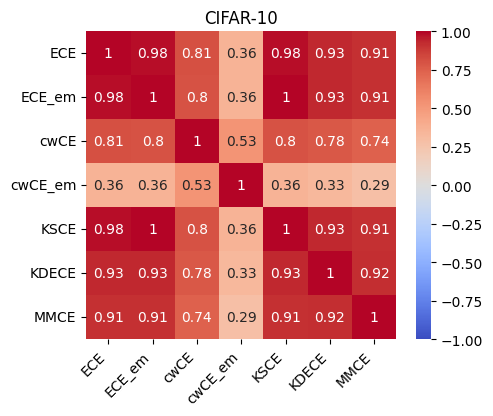

In [101]:
# Create a correlation heatmap using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('CIFAR-10')
plt.xticks(rotation=45, ha='right')
plt.savefig("fig/Kendall_Metric_C10.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [84]:
corr_matrix.columns = ['ECE', 'ECE_em', 'cwCE', 'cwCE_em', 'KSCE',
       'KDECE', 'MMCE']

In [86]:
corr_matrix.index = ['ECE', 'ECE_em', 'cwCE', 'cwCE_em', 'KSCE',
       'KDECE', 'MMCE']

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['C100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['C100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)


In [ ]:

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.savefig("fig/Kendall_Metric_C100.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [15]:
df_imagenet

,config,info,dataset,arch,ECE,ECE_em,cwCE,KSCE,KDECE,MMCE,ECE_imagenet,ECE_em_imagenet,cwCE_imagenet,KSCE_imagenet,KDECE_imagenet,MMCE_imagenet
0,0,0.276667,ImageNet16-120,|avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~...,"{'n_bins': 5, 'result': 0.00945469532410305}, ...","{'debias': False, 'num_bins': 5, 'mode': 'top-...","{'n_bins': 5, 'result': 0.0013792490441096661}...",{'result': 0.009119409918785099},"{'p_int': None, 'order': 1, 'result': 0.016285...",{'result': 0.007054624534448918},0.013479,0.014891,0.002200,0.009119,0.016285,0.007055
1,1,0.451167,ImageNet16-120,|nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~...,"{'n_bins': 5, 'result': 0.09272577808300654}, ...","{'debias': False, 'num_bins': 5, 'mode': 'top-...","{'n_bins': 5, 'result': 0.0021656821540904482}...",{'result': 0.09272800747553506},"{'p_int': None, 'order': 1, 'result': 0.090597...",{'result': 0.06927212091535173},0.092726,0.092726,0.003150,0.092728,0.090597,0.069272
2,2,0.275833,ImageNet16-120,|avg_pool_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~...,"{'n_bins': 5, 'result': 0.006255903825163834},...","{'debias': False, 'num_bins': 5, 'mode': 'top-...","{'n_bins': 5, 'result': 0.0012907429582542844}...",{'result': 0.007433654725551603},"{'p_int': None, 'order': 1, 'result': 0.014923...",{'result': 0.004274000826165804},0.014164,0.015447,0.002181,0.007434,0.014924,0.004274
3,3,0.288333,ImageNet16-120,|avg_pool_3x3~0|+|skip_connect~0|none~1|+|none...,"{'n_bins': 5, 'result': 0.00953824260085822}, ...","{'debias': False, 'num_bins': 5, 'mode': 'top-...","{'n_bins': 5, 'result': 0.001377999333548683},...",{'result': 0.006462705612182623},"{'p_int': None, 'order': 1, 'result': 0.012709...",{'result': 0.004177485547317534},0.016188,0.014983,0.002250,0.006463,0.012710,0.004177
4,4,0.314333,ImageNet16-120,|skip_connect~0|+|skip_connect~0|nor_conv_1x1~...,"{'n_bins': 5, 'result': 0.020774038607875498},...","{'debias': False, 'num_bins': 5, 'mode': 'top-...","{'n_bins': 5, 'result': 0.001504676621626681},...",{'result': 0.020939711650212633},"{'p_int': None, 'order': 1, 'result': 0.021252...",{'result': 0.016234535409858773},0.021022,0.025559,0.002518,0.020940,0.021253,0.016235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6461,3101,0.386167,ImageNet16-120,|nor_conv_3x3~0|+|skip_connect~0|avg_pool_3x3~...,"{'n_bins': 5, 'result': 0.03692361749708652}, ...","{'debias': False, 'num_bins': 5, 'mode': 'top-...","{'n_bins': 5, 'result': 0.001654511819542677},...",{'result': 0.037223105271657286},"{'p_int': None, 'order': 1, 'result': 0.037605...",{'result': 0.02717772313831015},0.036924,0.036924,0.002655,0.037223,0.037605,0.027178
6462,3103,0.388167,ImageNet16-120,|skip_connect~0|+|none~0|nor_conv_3x3~1|+|nor_...,"{'n_bins': 5, 'result': 0.06361562371750673}, ...","{'debias': False, 'num_bins': 5, 'mode': 'top-...","{'n_bins': 5, 'result': 0.0018401854222781066}...",{'result': 0.06361810994148254},"{'p_int': None, 'order': 1, 'result': 0.063317...",{'result': 0.0479860797053282},0.063616,0.065159,0.002854,0.063618,0.063317,0.047986
6463,3106,0.363167,ImageNet16-120,|avg_pool_3x3~0|+|none~0|nor_conv_1x1~1|+|skip...,"{'n_bins': 5, 'result': 0.045511537753045554},...","{'debias': False, 'num_bins': 5, 'mode': 'top-...","{'n_bins': 5, 'result': 0.0015957144398758018}...",{'result': 0.045571782747904466},"{'p_int': None, 'order': 1, 'result': 0.047629...",{'result': 0.03419498794444638},0.045512,0.045512,0.002601,0.045572,0.047630,0.034195
6464,3107,0.265167,ImageNet16-120,|avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~...,"{'n_bins': 5, 'result': 0.018903581733504933},...","{'debias': False, 'num_bins': 5, 'mode': 'top-...","{'n_bins': 5, 'result': 0.0013174213220229528}...",{'result': 0.019142753283182767},"{'p_int': None, 'order': 1, 'result': 0.024367...",{'result': 0.015722511699214743},0.022501,0.020349,0.002253,0.019143,0.024368,0.015723


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman

In [ ]:
df_imagenet = pd.read_csv('./final_results/sss/imagenet_sss.csv')

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman


In [3]:
df_imagenet = pd.read_csv('./final_results/sss/imagenet_sss.csv')
df_cifar10 = pd.read_csv('./final_results/sss/cifar10_sss.csv')
df_cifar100 = pd.read_csv('./final_results/sss/cifar100_sss.csv')

In [4]:


def get_ece_15_bins(ece_str):
    ece_data = eval(ece_str)
    for ece_entry in ece_data:
        if ece_entry['n_bins'] == 15:
            return ece_entry['result']
    return None

def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

In [5]:
metrics_to_extract = [
    'ece', 'ece_em', 'cwECE',
       'cwECE_em'
]

df_imagenet = df_imagenet[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
# 
metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE',
       'cwCE_em'
]
df_imagenet.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
for metric in metrics_to_extract:
    for dataset, df in [('imagenet', df_imagenet), ('cifar10', df_cifar10), ('cifar100', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))

In [6]:
merged_df = df_imagenet[['config'] + [f"{metric}_imagenet" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_cifar10" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_cifar100" for metric in metrics_to_extract]], on='config', how='outer'
)

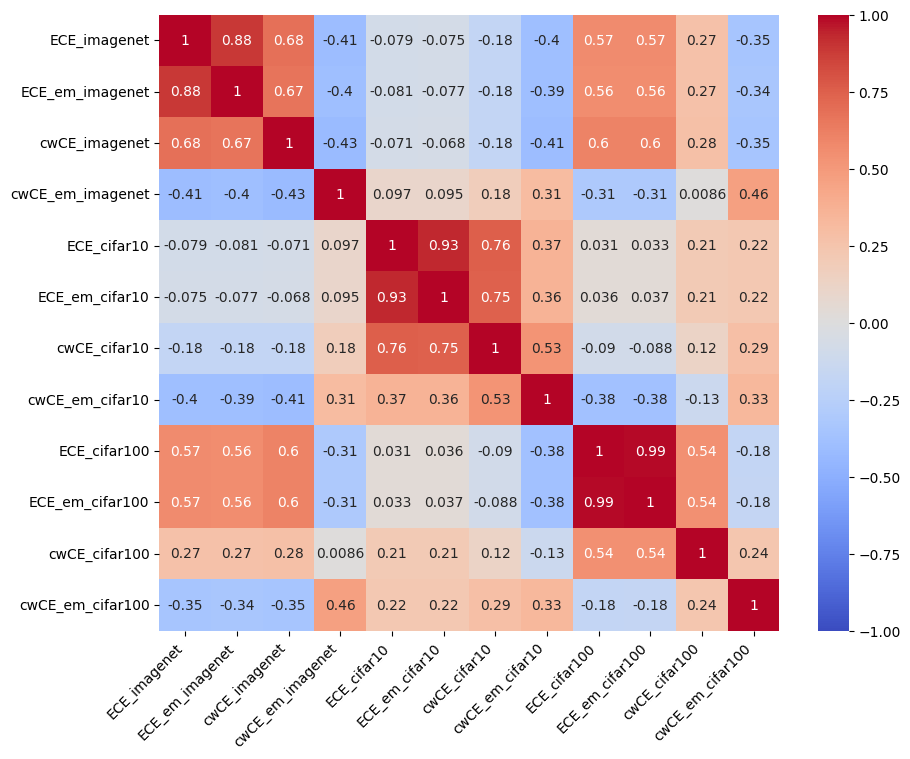

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['imagenet', 'cifar10', 'cifar100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['imagenet', 'cifar10', 'cifar100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(rotation=45, ha='right')
plt.savefig("fig/Kendall_Metric_sss.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

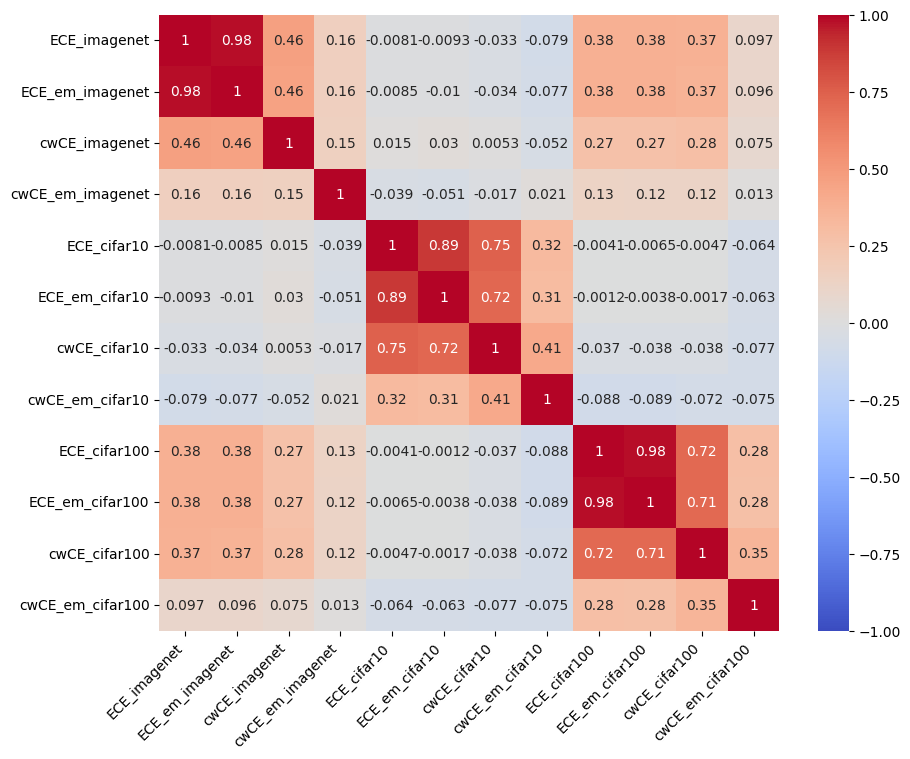

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman

df_imagenet = pd.read_csv('./final_results/sss/imagenet_sss.csv')
df_cifar10 = pd.read_csv('./final_results/sss/cifar10_sss.csv')
df_cifar100 = pd.read_csv('./final_results/sss/cifar100_sss.csv')



def get_ece_15_bins(ece_str):
    ece_data = eval(ece_str)
    for ece_entry in ece_data:
        if ece_entry['n_bins'] == 15:
            return ece_entry['result']
    return None

def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

metrics_to_extract = [
    'ece', 'ece_em', 'cwECE',
       'cwECE_em'
]

df_imagenet = df_imagenet[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
# 
metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE',
       'cwCE_em'
]
df_imagenet.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
for metric in metrics_to_extract:
    for dataset, df in [('imagenet', df_imagenet), ('cifar10', df_cifar10), ('cifar100', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))


merged_df = df_imagenet[['config'] + [f"{metric}_imagenet" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_cifar10" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_cifar100" for metric in metrics_to_extract]], on='config', how='outer'
)

top_config_df1 = df_imagenet.nlargest(100, 'info')['config']
top_config_df2 = df_cifar10.nlargest(100, 'info')['config']
top_config_df3 = df_cifar100.nlargest(100, 'info')['config']

# Concatenate these Series into a single Series
config_frames = [top_config_df1, top_config_df2, top_config_df3]
config_result = pd.concat(config_frames)

# Drop duplicates
unique_config_result = config_result.drop_duplicates()

# If you want to reset the index
unique_config_result = unique_config_result.reset_index(drop=True)

merged_df = merged_df.loc[merged_df['config'].isin(unique_config_result)]

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['imagenet', 'cifar10', 'cifar100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['imagenet', 'cifar10', 'cifar100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title("SSS Kendall Ranking Correlation Heatmap")
plt.xticks(rotation=45, ha='right')
plt.savefig("fig/Kendall_Metric_sss_100.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()


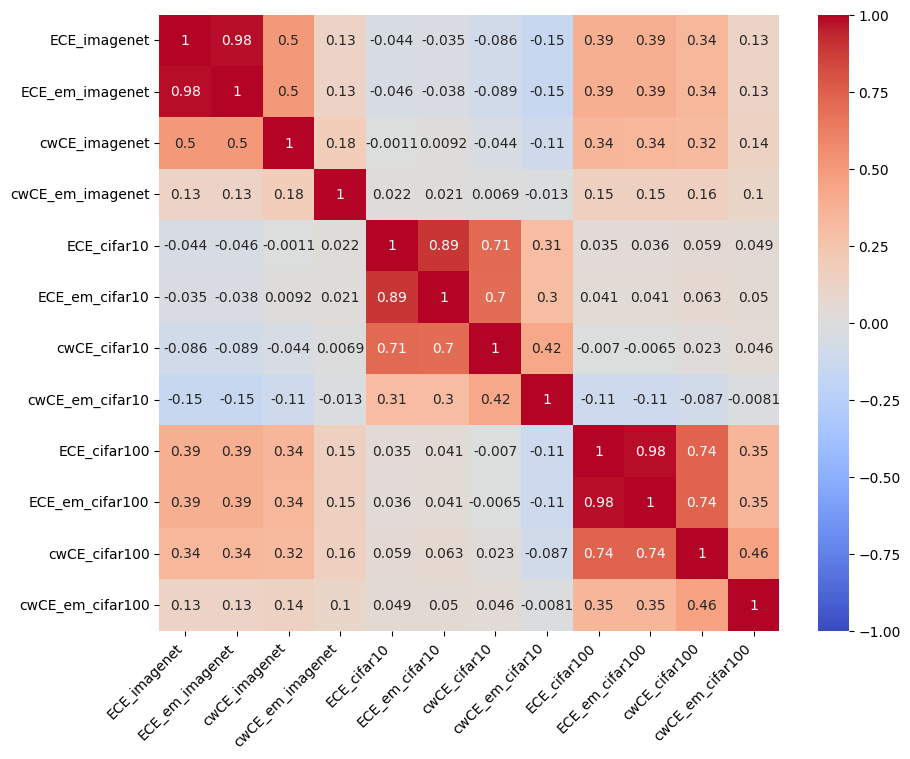

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman

df_imagenet = pd.read_csv('./final_results/sss/imagenet_sss.csv')
df_cifar10 = pd.read_csv('./final_results/sss/cifar10_sss.csv')
df_cifar100 = pd.read_csv('./final_results/sss/cifar100_sss.csv')



def get_ece_15_bins(ece_str):
    ece_data = eval(ece_str)
    for ece_entry in ece_data:
        if ece_entry['n_bins'] == 15:
            return ece_entry['result']
    return None

def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

metrics_to_extract = [
    'ece', 'ece_em', 'cwECE',
       'cwECE_em'
]

df_imagenet = df_imagenet[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
# 
metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE',
       'cwCE_em'
]
df_imagenet.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
for metric in metrics_to_extract:
    for dataset, df in [('imagenet', df_imagenet), ('cifar10', df_cifar10), ('cifar100', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))


merged_df = df_imagenet[['config'] + [f"{metric}_imagenet" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_cifar10" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_cifar100" for metric in metrics_to_extract]], on='config', how='outer'
)

top_config_df1 = df_imagenet.nlargest(1000, 'info')['config']
top_config_df2 = df_cifar10.nlargest(1000, 'info')['config']
top_config_df3 = df_cifar100.nlargest(1000, 'info')['config']

# Concatenate these Series into a single Series
config_frames = [top_config_df1, top_config_df2, top_config_df3]
config_result = pd.concat(config_frames)

# Drop duplicates
unique_config_result = config_result.drop_duplicates()

# If you want to reset the index
unique_config_result = unique_config_result.reset_index(drop=True)

merged_df = merged_df.loc[merged_df['config'].isin(unique_config_result)]

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['imagenet', 'cifar10', 'cifar100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['imagenet', 'cifar10', 'cifar100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title("SSS Kendall Ranking Correlation Heatmap")
plt.xticks(rotation=45, ha='right')
plt.savefig("fig/Kendall_Metric_sss_1000.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()


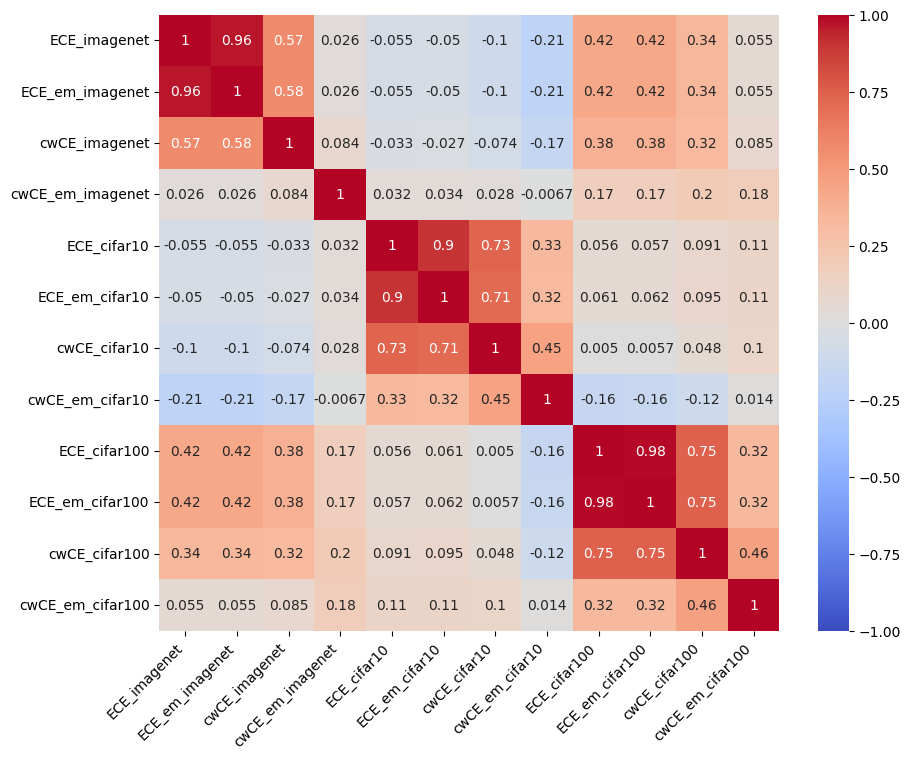

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman

df_imagenet = pd.read_csv('./final_results/sss/imagenet_sss.csv')
df_cifar10 = pd.read_csv('./final_results/sss/cifar10_sss.csv')
df_cifar100 = pd.read_csv('./final_results/sss/cifar100_sss.csv')



def get_ece_15_bins(ece_str):
    ece_data = eval(ece_str)
    for ece_entry in ece_data:
        if ece_entry['n_bins'] == 15:
            return ece_entry['result']
    return None

def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

metrics_to_extract = [
    'ece', 'ece_em', 'cwECE',
       'cwECE_em'
]

df_imagenet = df_imagenet[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
# 
metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE',
       'cwCE_em'
]
df_imagenet.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
for metric in metrics_to_extract:
    for dataset, df in [('imagenet', df_imagenet), ('cifar10', df_cifar10), ('cifar100', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))


merged_df = df_imagenet[['config'] + [f"{metric}_imagenet" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_cifar10" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_cifar100" for metric in metrics_to_extract]], on='config', how='outer'
)

top_config_df1 = df_imagenet.nlargest(5000, 'info')['config']
top_config_df2 = df_cifar10.nlargest(5000, 'info')['config']
top_config_df3 = df_cifar100.nlargest(5000, 'info')['config']

# Concatenate these Series into a single Series
config_frames = [top_config_df1, top_config_df2, top_config_df3]
config_result = pd.concat(config_frames)

# Drop duplicates
unique_config_result = config_result.drop_duplicates()

# If you want to reset the index
unique_config_result = unique_config_result.reset_index(drop=True)

merged_df = merged_df.loc[merged_df['config'].isin(unique_config_result)]

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['imagenet', 'cifar10', 'cifar100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['imagenet', 'cifar10', 'cifar100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title("SSS Kendall Ranking Correlation Heatmap")
plt.xticks(rotation=45, ha='right')
plt.savefig("fig/Kendall_Metric_sss_5000.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()


In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman

df_imagenet = pd.read_csv('./final_results/sss/imagenet_sss.csv')
df_cifar10 = pd.read_csv('./final_results/sss/cifar10_sss.csv')
df_cifar100 = pd.read_csv('./final_results/sss/cifar100_sss.csv')


def get_ece_15_bins(ece_str):
    ece_data = eval(ece_str)
    for ece_entry in ece_data:
        if ece_entry['n_bins'] == 15:
            return ece_entry['result']
    return None

def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

metrics_to_extract = [
    'ece', 'ece_em', 'cwECE',
       'cwECE_em'
]

df_imagenet = df_imagenet[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
# 
metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE',
       'cwCE_em'
]
df_imagenet.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
for metric in metrics_to_extract:
    for dataset, df in [('imagenet', df_imagenet), ('cifar10', df_cifar10), ('cifar100', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))



imagenet_ids = df_imagenet.sort_values('info', ascending=False).head(3000)['config']
cifar10_ids = df_cifar10.sort_values('info', ascending=False).head(3000)['config']
cifar100_ids = df_cifar100.sort_values('info', ascending=False).head(3000)['config']

ids = list(set(list(imagenet_ids) + list(cifar10_ids)+list(cifar100_ids)))

merged_df = df_imagenet[['config'] + [f"{metric}_imagenet" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_cifar10" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_cifar100" for metric in metrics_to_extract]], on='config', how='outer'
)

plot_df = merged_df.loc[merged_df['config'].isin(ids)]

/tmp/ipykernel_1689806/3601988339.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[rank_column_name] = plot_df[column_name].rank(method='dense', ascending=False)


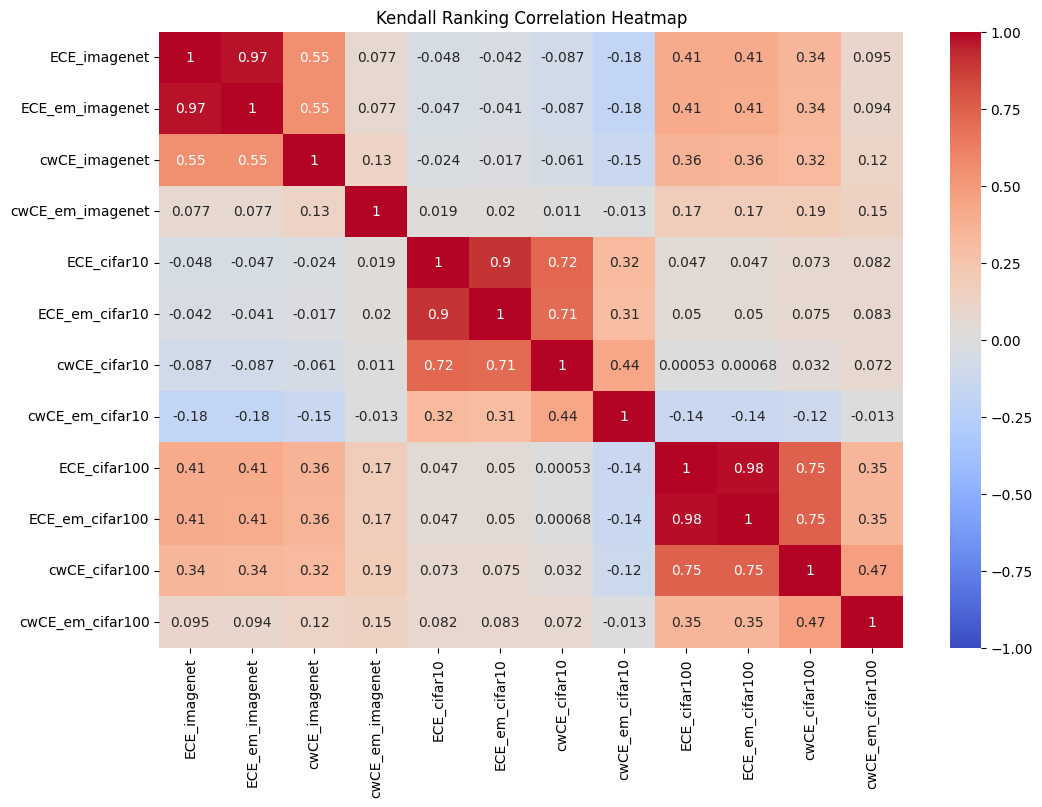

In [51]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['imagenet', 'cifar10', 'cifar100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        plot_df[rank_column_name] = plot_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['imagenet', 'cifar10', 'cifar100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(plot_df[col1], plot_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Kendall Ranking Correlation Heatmap")
# plt.savefig("fig/Kendall_Metric.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
df_imagenet = pd.read_csv('./final_results/sss/imagenet_sss.csv')
df_cifar10 = pd.read_csv('./final_results/sss/cifar10_sss.csv')
df_cifar100 = pd.read_csv('./final_results/sss/cifar100_sss.csv')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman

df_imagenet = pd.read_csv('./final_results/sss/imagenet_sss.csv')
df_cifar10 = pd.read_csv('./final_results/sss/cifar10_sss.csv')
df_cifar100 = pd.read_csv('./final_results/sss/cifar100_sss.csv')


def get_ece_15_bins(ece_str):
    ece_data = eval(ece_str)
    for ece_entry in ece_data:
        if ece_entry['n_bins'] == 15:
            return ece_entry['result']
    return None

def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

metrics_to_extract = [
    'ece', 'ece_em', 'cwECE',
       'cwECE_em'
]

df_imagenet = df_imagenet[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'info', 'dataset', 'arch'] +metrics_to_extract]
# 
metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE',
       'cwCE_em'
]
df_imagenet.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar10.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
df_cifar100.columns = ['config', 'info', 'dataset', 'arch'] +metrics_to_extract
for metric in metrics_to_extract:
    for dataset, df in [('imagenet', df_imagenet), ('cifar10', df_cifar10), ('cifar100', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))




imagenet_ids = df_imagenet.sort_values('info', ascending=False).head(1000)['config']
cifar10_ids = df_cifar10.sort_values('info', ascending=False).head(1000)['config']
cifar100_ids = df_cifar100.sort_values('info', ascending=False).head(1000)['config']

ids = list(set(list(imagenet_ids) + list(cifar10_ids)+list(cifar100_ids)))

merged_df = df_imagenet[['config'] + [f"{metric}_imagenet" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_cifar10" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_cifar100" for metric in metrics_to_extract]], on='config', how='outer'
)

plot_df = merged_df.loc[merged_df['config'].isin(ids)]

In [56]:
df_cifar10.sort_values('info', ascending=False).head(1000).columns

Index(['config', 'info', 'dataset', 'arch', 'ECE', 'ECE_em', 'cwCE', 'cwCE_em',
       'ECE_cifar10', 'ECE_em_cifar10', 'cwCE_cifar10', 'cwCE_em_cifar10'],
      dtype='object')

/tmp/ipykernel_1689806/3601988339.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[rank_column_name] = plot_df[column_name].rank(method='dense', ascending=False)


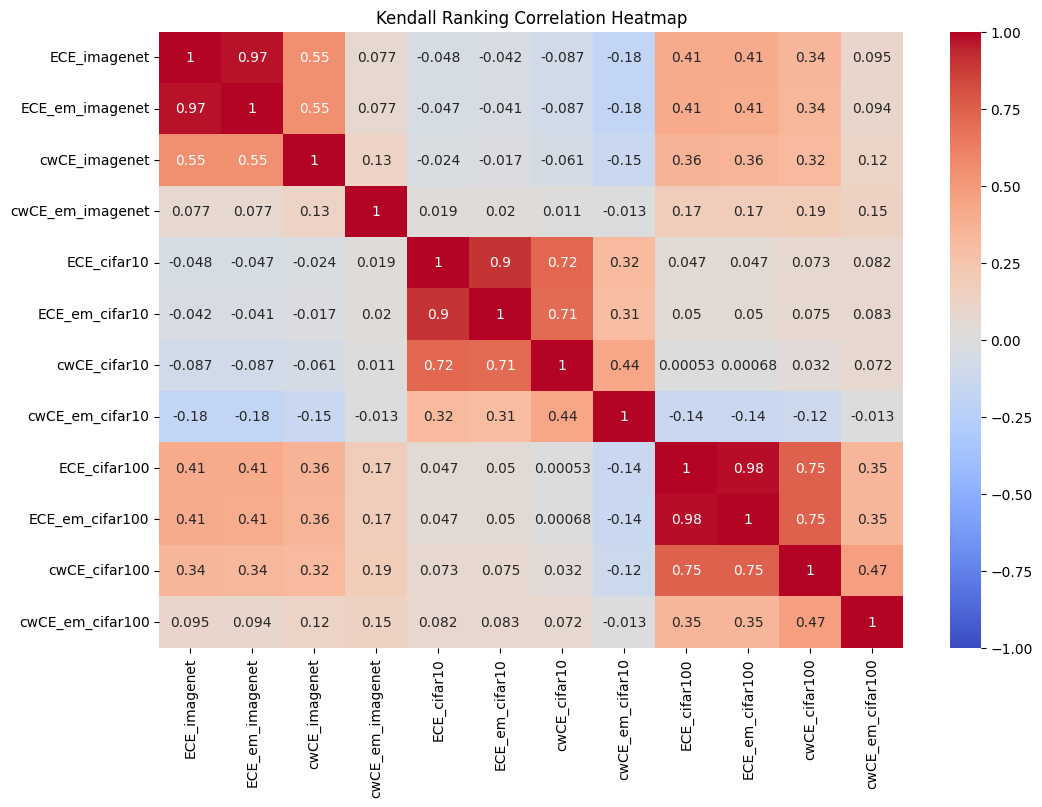

In [52]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['imagenet', 'cifar10', 'cifar100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        plot_df[rank_column_name] = plot_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['imagenet', 'cifar10', 'cifar100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(plot_df[col1], plot_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Kendall Ranking Correlation Heatmap")
# plt.savefig("fig/Kendall_Metric.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

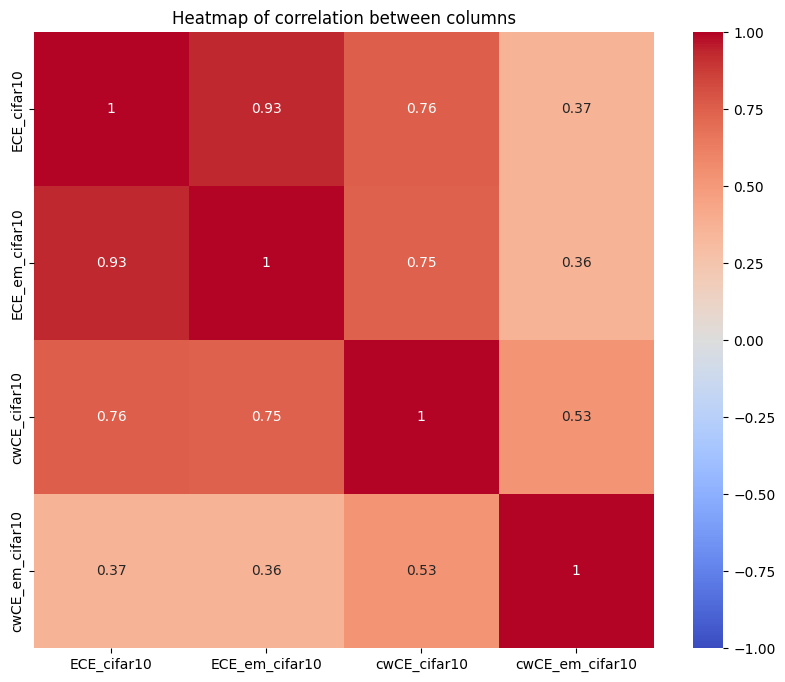

In [79]:


correlation_matrix = df_cifar10.sort_values('info', ascending=False).head(1000)[['ECE_cifar10', 'ECE_em_cifar10', 'cwCE_cifar10', 'cwCE_em_cifar10']].corr(method='kendall')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of correlation between columns')
plt.show()

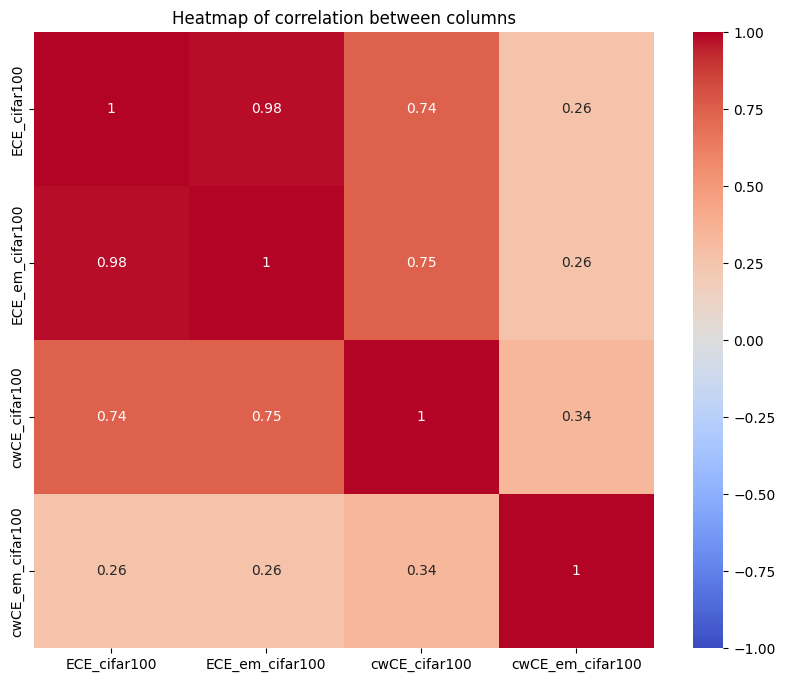

In [82]:


correlation_matrix = df_cifar100.sort_values('info', ascending=False).head(1000)[['ECE_cifar100', 'ECE_em_cifar100', 'cwCE_cifar100', 'cwCE_em_cifar100']].corr(method='kendall')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of correlation between columns')
plt.show()

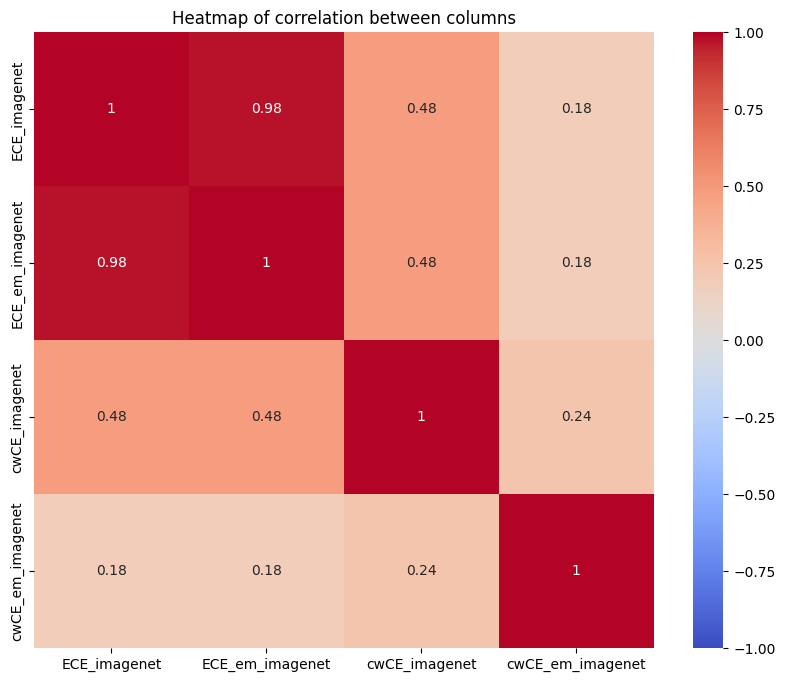

In [88]:


correlation_matrix = df_imagenet.sort_values('info', ascending=False).head(1000)[['ECE_imagenet', 'ECE_em_imagenet', 'cwCE_imagenet', 'cwCE_em_imagenet']].corr(method='kendall')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of correlation between columns')
plt.show()

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman



df_imagenet = pd.read_csv('public_results/imagenet_results.csv')
df_cifar10 = pd.read_csv('public_results/cifar10_results.csv')
df_cifar100 = pd.read_csv('public_results/cifar100_results.csv')

In [17]:
df_cifar10.columns

Index(['config', 'acc', 'dataset', 'arch', 'ECE_5', 'ECE_10', 'ECE_15',
       'ECE_20', 'ECE_25', 'ECE_50', 'ECE_100', 'ECE_200', 'ECE_500',
       'ECE_em_5', 'ECE_em_10', 'ECE_em_15', 'ECE_em_20', 'ECE_em_25',
       'ECE_em_50', 'ECE_em_100', 'ECE_em_200', 'ECE_em_500', 'cwCE_5',
       'cwCE_10', 'cwCE_15', 'cwCE_20', 'cwCE_25', 'cwCE_50', 'cwCE_100',
       'cwCE_200', 'cwCE_500', 'cwCE_em_5', 'cwCE_em_10', 'cwCE_em_15',
       'cwCE_em_20', 'cwCE_em_25', 'cwCE_em_50', 'cwCE_em_100', 'cwCE_em_200',
       'cwCE_em_500', 'MCE_5', 'MCE_10', 'MCE_15', 'MCE_20', 'MCE_25',
       'MCE_50', 'MCE_100', 'MCE_200', 'MCE_500', 'KSCE', 'KDECE', 'MMCE',
       'NLL', 'Brier'],
      dtype='object')

In [ ]:
'ECE', 'ECE_em', 'cwCE','KSCE', 'KDECE', 'MMCE','cwCE_em'

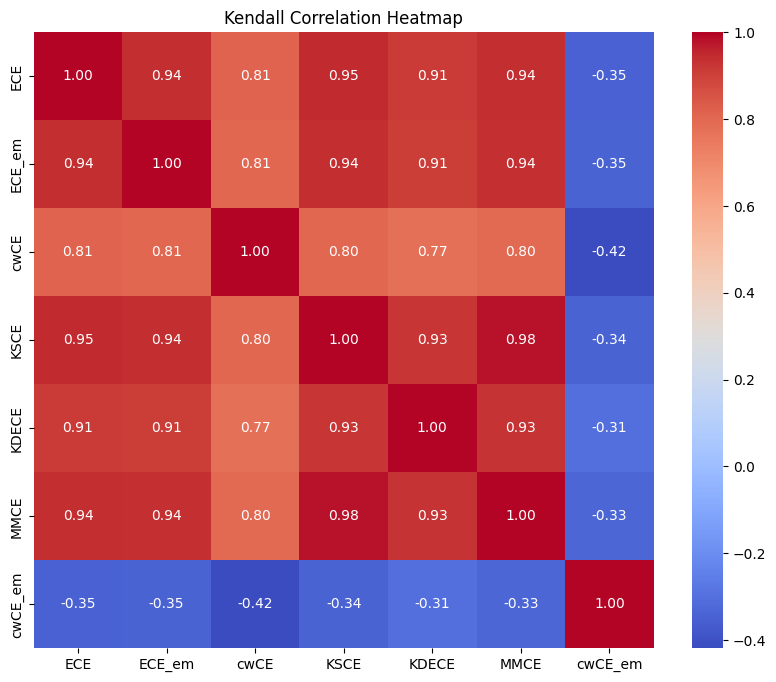

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# Assuming the dataframe is named df



# Select the columns you're interested in
selected_columns = ['ECE_15', 'ECE_em_15', 'cwCE_15', 'KSCE', 'KDECE', 'MMCE', 'cwCE_em_15']

selected_df = df_imagenet[selected_columns]
selected_df.columns = ['ECE', 'ECE_em', 'cwCE','KSCE', 'KDECE', 'MMCE','cwCE_em']

# Calculate the correlation matrix
correlation_matrix = selected_df.corr(method='kendall')


# Draw the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Kendall Correlation Heatmap')
plt.show()

In [25]:
correlation_matrix

,$ECE\_15$,$ECE\_{\mathrm{em}}\_15$,$cwCE\_15$,$cwCE\_{\mathrm{em}}\_15$,$KSCE$,$KDECE$,$MMCE$
$ECE\_15$,1.000000,0.981754,0.794622,0.258379,0.980600,0.858499,0.908627
$ECE\_{\mathrm{em}}\_15$,0.981754,1.000000,0.792985,0.256530,0.997195,0.858819,0.909936
$cwCE\_15$,0.794622,0.792985,1.000000,0.444022,0.791201,0.700639,0.725699
$cwCE\_{\mathrm{em}}\_15$,0.258379,0.256530,0.444022,1.000000,0.254541,0.297652,0.180325
$KSCE$,0.980600,0.997195,0.791201,0.254541,1.000000,0.858261,0.910880
$KDECE$,0.858499,0.858819,0.700639,0.297652,0.858261,1.000000,0.824877
$MMCE$,0.908627,0.909936,0.725699,0.180325,0.910880,0.824877,1.000000
